#### Problem Statement: 
I’m focusing on understanding and applying Double Machine Learning (DML) to find causal connections in datasets. Using the Titanic dataset, I aim to analyze how certain factors, like the class of passengers, might have affected their chances of survival. EconML will guide in this investigation.

#### Objectives:
* Apply causal inference techniques to understand the impact of treatments (like passenger class) on the outcome (survival).
* Implement DML using EconML to analyze the Titanic dataset, drawing insights into causal effects.
* Explore and identify causal relationships within the Titanic dataset using EconML, focusing on how passenger characteristics influence survival chances.

This assignment offered me a practical introduction to causal inference, highlighting the utility of EconML in analyzing real-world data for impactful insights.

#### Datasets: 
The Titanic dataset, split into training and test sets, provides data on passenger characteristics and survival outcomes, serving as the basis for causal analysis.

#### Modeling Methodology:
* The dataset was divided into treatment (passenger class), features (age, sex, fare, etc.), and target (survival).
* The treatment was coded as binary, distinguishing between 1st class and other classes.
* A LinearDML model using XGBoost for the treatment effect and Lasso regression for outcome estimation was employed to calculate the Average Treatment Effect (ATE) of passenger class on survival.
* The model was trained on the training set and assessed on a test set to gauge its reliability.
* SHAP values were used to interpret the model, providing insights into the direction and magnitude of the features' effects on survival.


### Importing Relevant Libraries

In [97]:
!pip install econml
!pip install shap
!pip install Lightgbm

# Data wrangling and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import _tree

# Preprocessing libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Modeling libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from econml.dml import LinearDML, CausalForestDML
from econml.metalearners import XLearner, SLearner, TLearner
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# importing evaluation libraries
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
import importlib

# List of package names
packages = ["causalml", "econml", "dowhy", "pandas", "numpy", "scipy", "sklearn", "matplotlib", "seaborn"]

for package in packages:
    try:
        # Dynamically import the package
        pkg = importlib.import_module(package)
        # Attempt to print the package version, handling AttributeError
        version = getattr(pkg, '__version__', 'Version attribute not available')
        print(f"{package}: {version}")
    except ModuleNotFoundError:
        print(f"{package}: Not installed")

causalml: Not installed
econml: 0.15.0
dowhy: Not installed
pandas: 1.5.3
numpy: 1.23.5
scipy: 1.10.0
sklearn: 1.2.1
matplotlib: 3.7.0
seaborn: 0.12.2


In [22]:
train_data = pd.read_csv("C:/Users/mehri/Downloads/train.csv")
test_data = pd.read_csv("C:/Users/mehri/Downloads/test.csv")

In [7]:
# Display the first few rows of the train dataset
display(train_data.head())

print("\n")

# Display the first few rows of the test dataset
display(test_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Exploratory Data Analysis

In [8]:
print(train_data.shape)
print(test_data.shape)

(891, 12)
(418, 11)


In [74]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    int64   
 3   Name           891 non-null    object  
 4   Sex            891 non-null    object  
 5   Age            891 non-null    int32   
 6   SibSp          891 non-null    int64   
 7   Parch          891 non-null    int64   
 8   Ticket         891 non-null    object  
 9   Fare           891 non-null    float64 
 10  Cabin          204 non-null    object  
 11  Embarked       889 non-null    object  
 12  Age_Category   891 non-null    category
 13  Fare_Category  891 non-null    int32   
dtypes: category(1), float64(1), int32(2), int64(5), object(5)
memory usage: 84.9+ KB


In [143]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Fare_Category
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,23.783389,0.523008,0.381594,32.204208,0.860831
std,257.353842,0.486592,0.836071,17.597344,1.102743,0.806057,49.693429,0.406054
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,6.000000,0.000000,0.000000,7.910400,1.000000
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,2.000000


In [29]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Summary statistics for numerical variables
print(train_data.describe())

# Check for missing values
print(train_data.isnull().sum())

# Basic analysis of categorical variables
print(train_data['Survived'].value_counts())
print(train_data['Pclass'].value_counts())
print(train_data['Sex'].value_counts())
print(train_data['Embarked'].value_counts())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex  

In [10]:
# Set the visual style of seaborn
sns.set(style="whitegrid")

# Summary statistics for numerical variables
print("Summary Statistics for Numerical Variables:")
print(train_data.describe())
print("\n")

Summary Statistics for Numerical Variables:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  




Missing Values per Column:
Age         177
Cabin       687
Embarked      2
dtype: int64




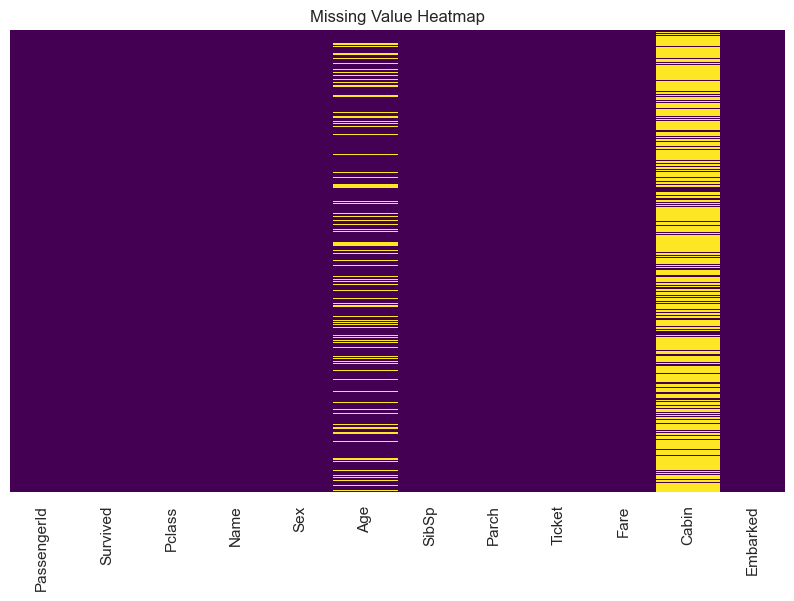

In [11]:
# Check for missing values
print("Missing Values per Column:")
missing_values = train_data.isnull().sum()
print(missing_values[missing_values > 0])
print("\n")

# Visual representation of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Value Heatmap')
plt.show()

In [61]:
# Shape of training data (num_rows, num_columns)
print(f'Train data shape:{train_data.shape}')

# Number of missing values in each column of training data
missing_val_count_by_column = (train_data.isnull().sum())
print("Missing values training data")
print( missing_val_count_by_column[missing_val_count_by_column > 0])


# Shape of training data (num_rows, num_columns)
print(f'Test data: {test_data.shape}')

# Number of missing values in each column of training data
missing_val_count_by_column = (test_data.isnull().sum())
print("Missing values training data")
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Train data shape:(891, 12)
Missing values training data
Age         177
Cabin       687
Embarked      2
dtype: int64
Test data: (418, 11)
Missing values training data
Age       86
Fare       1
Cabin    327
dtype: int64


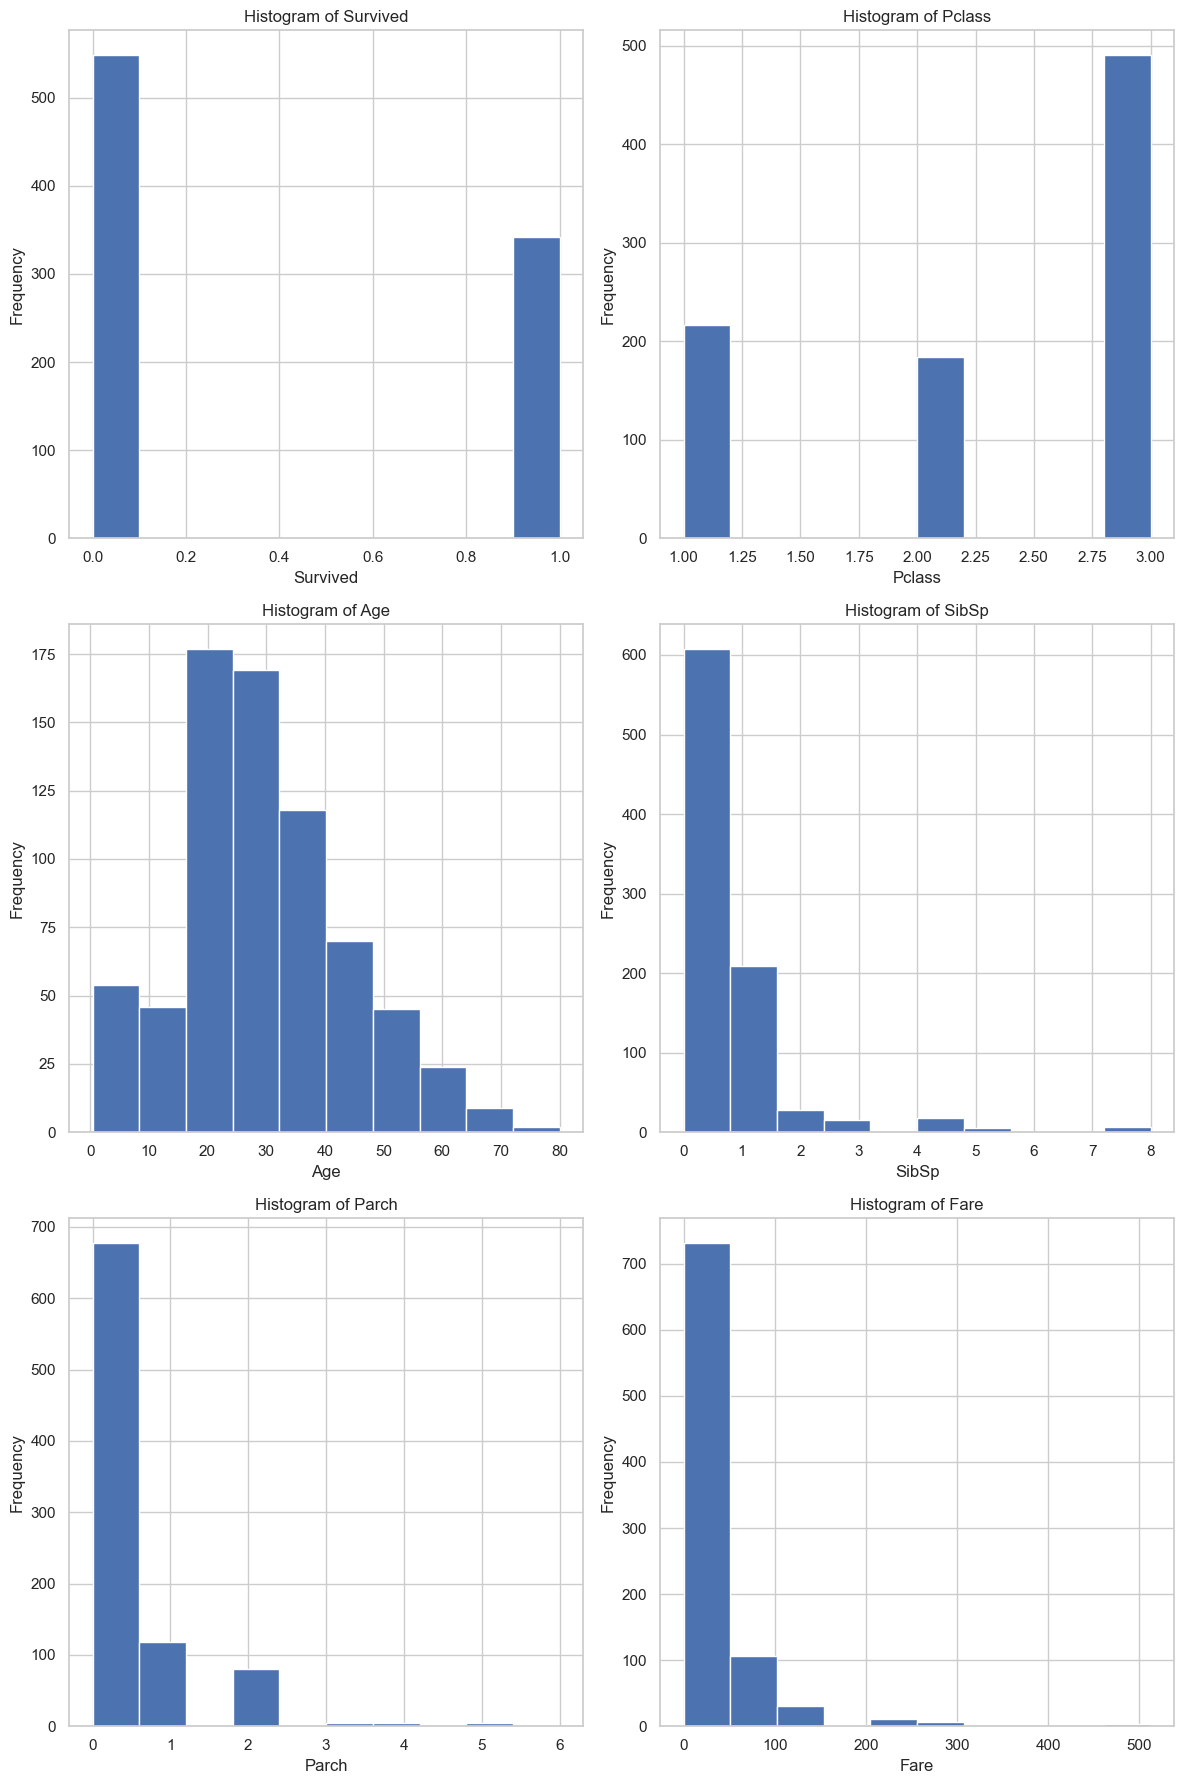

In [62]:
column_list = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
num_columns = len(column_list)
num_rows = (num_columns + 1) // 2

# Create a new figure with subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over each column in the dataframe
for i, column in enumerate(column_list):
    # Plot a histogram for the current column in the appropriate subplot
    axes[i].hist(train_data[column])
    axes[i].set_xlabel(column)  # Set the x-axis label as the column name
    axes[i].set_ylabel('Frequency')  # Set the y-axis label
    axes[i].set_title('Histogram of ' + column)  # Set the title of the subplot

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [63]:
t = pd.DataFrame(data={"col": train_data.dtypes.index, "type": train_data.dtypes}).reset_index(drop=True)
col_names = t["col"][t.type != "object"]
col_names

0    PassengerId
1       Survived
2         Pclass
5            Age
6          SibSp
7          Parch
9           Fare
Name: col, dtype: object

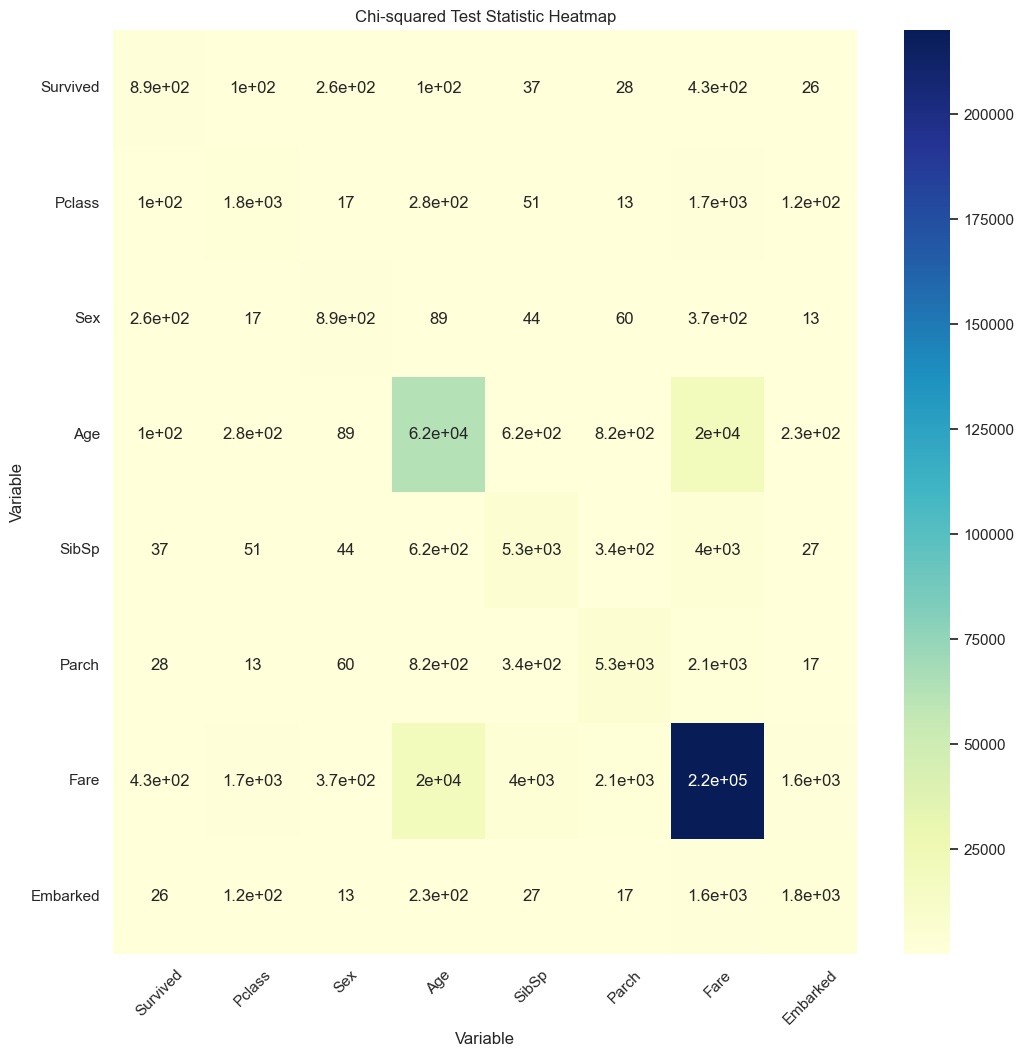

In [65]:
from scipy.stats import chi2_contingency

corrTrainData = train_data.drop(["Name", "Cabin", "PassengerId", "Ticket"], axis=1)

# Calculate the chi-squared test statistic between all pairs of categorical variables
chi2_matrix = pd.DataFrame(index=corrTrainData.columns, columns=corrTrainData.columns)
for col1 in corrTrainData.columns:
    for col2 in corrTrainData.columns:
        contingency_table = pd.crosstab(corrTrainData[col1], corrTrainData[col2])
        chi2, _, _, _ = chi2_contingency(contingency_table)
        chi2_matrix.loc[col1, col2] = chi2

# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(chi2_matrix.astype(float), annot=True, cmap="YlGnBu", ax=ax)

# Set the tick labels
ax.set_xticklabels(chi2_matrix.columns, rotation=45)
ax.set_yticklabels(chi2_matrix.columns, rotation=0)

# Set the axis labels
plt.xlabel("Variable")
plt.ylabel("Variable")
plt.title("Chi-squared Test Statistic Heatmap")


plt.show()

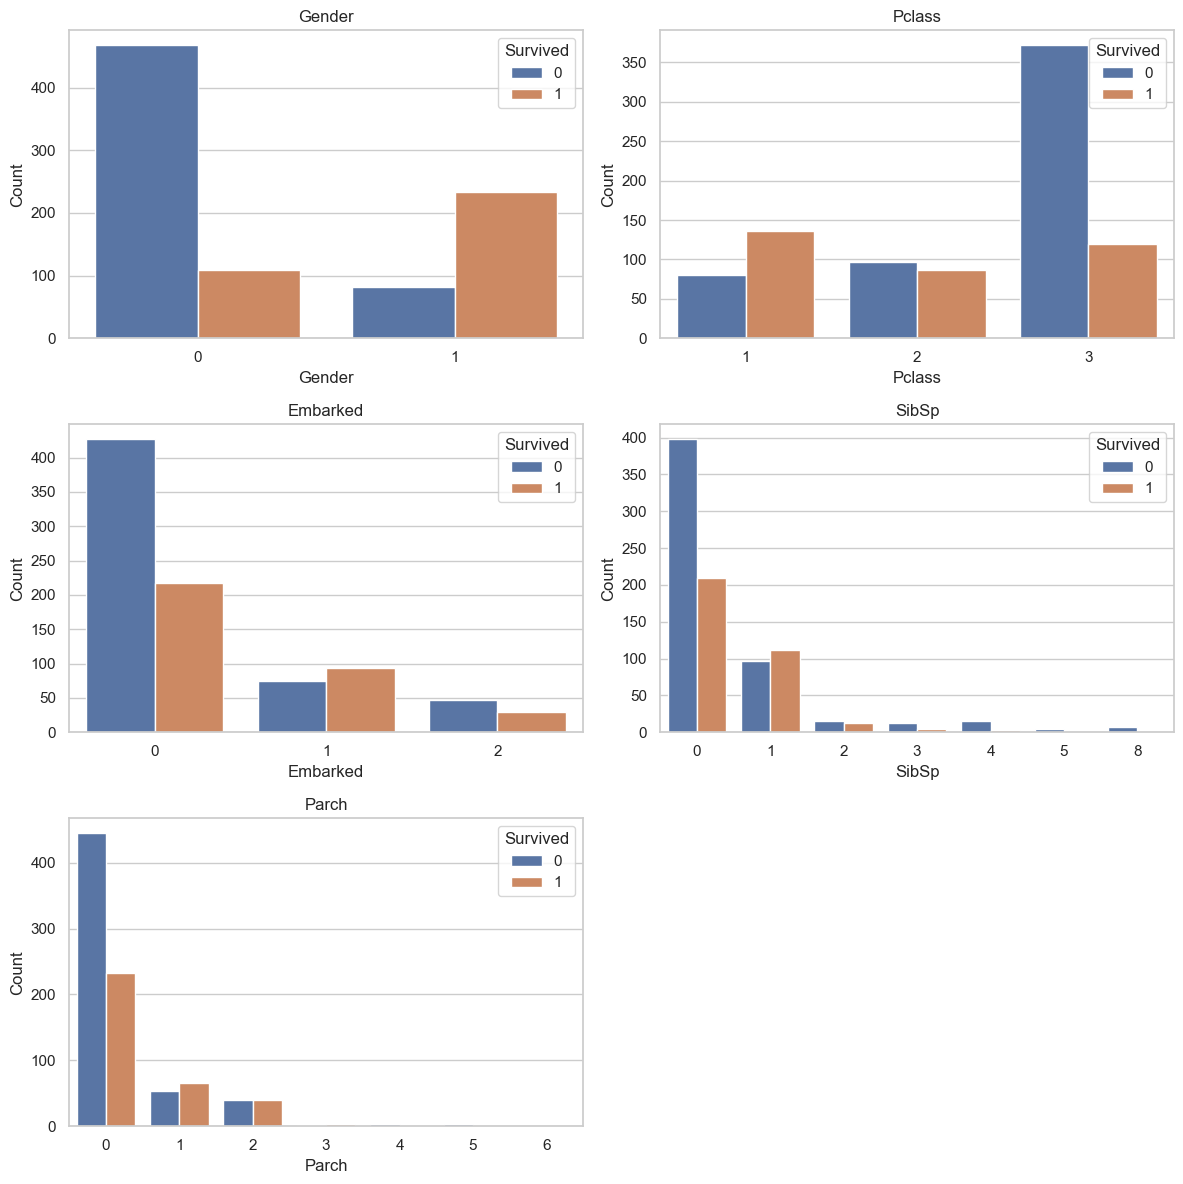

In [69]:
# Create a figure and subplots grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# First subplot: Pclass 1
sns.countplot(data=train_data, x='Sex', hue='Survived', ax=axes[0, 0])
axes[0, 0].set_title('Gender')
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Count')

# Second subplot: Pclass 2
sns.countplot(data=train_data, x='Pclass', hue='Survived', ax=axes[0, 1])
axes[0, 1].set_title('Pclass')
axes[0, 1].set_xlabel('Pclass')
axes[0, 1].set_ylabel('Count')

# Third subplot: Pclass 3
sns.countplot(data=train_data, x='Embarked', hue='Survived', ax=axes[1, 0])
axes[1, 0].set_title('Embarked')
axes[1, 0].set_xlabel('Embarked')
axes[1, 0].set_ylabel('Count')

# Fourth subplot: SibSp
sns.countplot(data=train_data, x='SibSp', hue='Survived', ax=axes[1, 1])
axes[1, 1].set_title('SibSp')
axes[1, 1].set_xlabel('SibSp')
axes[1, 1].set_ylabel('Count')
                      
# Fifth subplot: 
sns.countplot(data=train_data, x='Parch', hue='Survived', ax=axes[2, 0])
axes[2, 0].set_title('Parch')
axes[2, 0].set_xlabel('Parch')
axes[2, 0].set_ylabel('Count')

# Sixth subplot: Placeholder (turn off axis)
axes[2, 1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
# Create a figure and subplots grid

In [144]:
age_bins = [0, 3, 14, 20, 39, 49, 59, 69, 79, float('inf')]
age_labels = [1, 2, 3, 4, 5, 6, 7,8,9]

# Fill missing values with 0 and convert to integer type
train_data.fillna({"Age":0}, inplace=True)
train_data["Age"] = train_data["Age"].astype(int)

# Categorize age values into groups, including NaN values. nb needed to include this to 
train_data["Age_Category"] = pd.cut(train_data["Age"], bins=age_bins, labels=age_labels, include_lowest=True)

# Number of missing values in each column of training data
missing_val_count_by_column = (train_data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])


train_data.head()

Cabin       687
Embarked      2
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Category,Fare_Category
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,0,4,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,1,4,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,0,4,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,0,4,0
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,0,4,1


Cluster 1  - Center: [82.92256875]
Cluster 2  - Center: [15.3602868]
Cluster 3  - Center: [279.308545]


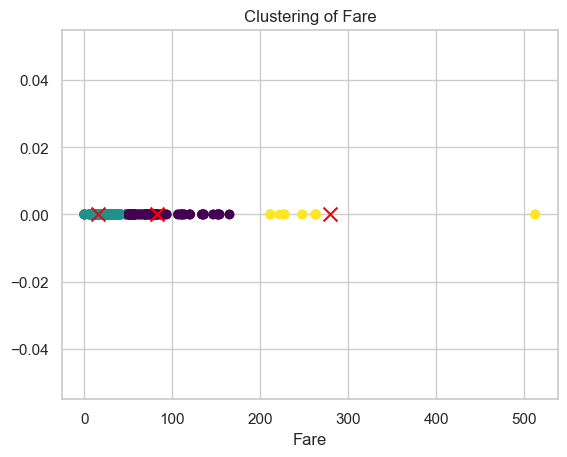

1    727
0    144
2     20
Name: Fare_Category, dtype: int64
Data type of fare_category: int32


In [145]:
from sklearn.cluster import KMeans

# Extract the "Fare" column from the dataset
fare_data = train_data["Fare"].values.reshape(-1, 1)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(fare_data)

# Get the cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Print the cluster labels and cluster centers
for i in range(len(centers)):
    print("Cluster", i+1, " - Center:", centers[i])

# Plot the data points with their corresponding cluster labels
plt.scatter(fare_data, np.zeros_like(fare_data), c=labels, cmap='viridis')
plt.scatter(centers, np.zeros_like(centers), c='red', marker='x', s=100)
plt.xlabel("Fare")
plt.title("Clustering of Fare")
plt.grid(True)

# Show the plot
plt.show()

# Add "fare_category" as a new variable to the dataset
train_data["Fare_Category"] = labels

# Print the cluster labels and their counts
print(train_data["Fare_Category"].value_counts())

# Print the first few rows of the updated dataset
train_data.head()

print("Data type of fare_category:", train_data["Fare_Category"].dtype)

In [146]:
#oneHot encoding does delete the orignal column/ variable name
encodedTrainData = pd.get_dummies(train_data, columns=['Fare_Category', 'Age_Category','Sex', 'Embarked'], drop_first=False, dtype=int)

encodedTrainData.head
encodedTrainData.columns
encodedTrainData

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Age_Category_5,Age_Category_6,Age_Category_7,Age_Category_8,Age_Category_9,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",22,1,0,A/5 21171,7.2500,NaN,...,0,0,0,0,0,1,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,1,0,PC 17599,71.2833,C85,...,0,0,0,0,0,0,1,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,0,0,0,1,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,1,0,113803,53.1000,C123,...,0,0,0,0,0,0,1,1,0,0
4,5,0,3,"Allen, Mr. William Henry",35,0,0,373450,8.0500,NaN,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27,0,0,211536,13.0000,NaN,...,0,0,0,0,0,1,0,1,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",19,0,0,112053,30.0000,B42,...,0,0,0,0,0,0,1,1,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,1,2,W./C. 6607,23.4500,NaN,...,0,0,0,0,0,0,1,1,0,0
889,890,1,1,"Behr, Mr. Karl Howell",26,0,0,111369,30.0000,C148,...,0,0,0,0,0,1,0,0,1,0


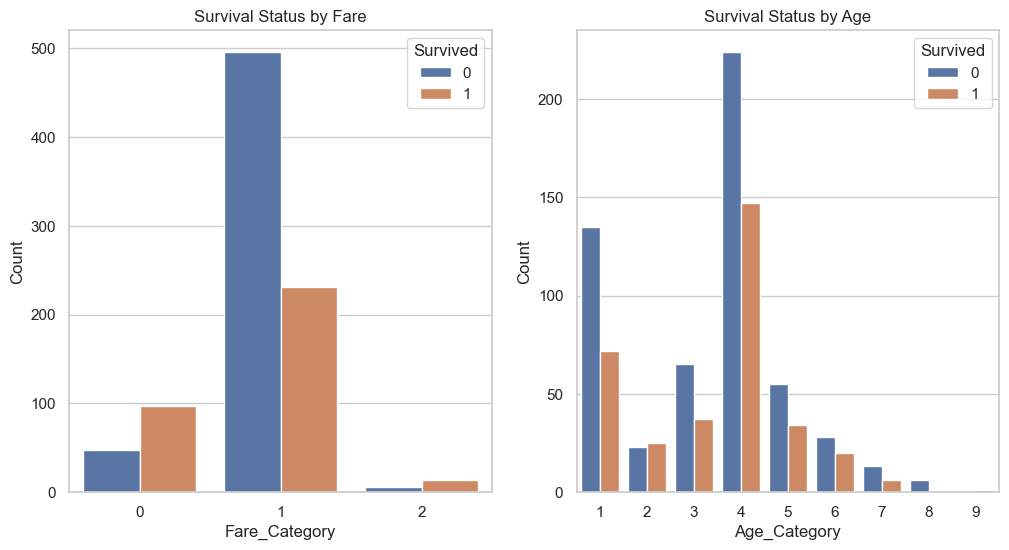

In [73]:
# Create a figure and subplots grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.countplot(data=train_data, x='Fare_Category', hue='Survived', ax=axes[0])
axes[0].set_title('Survival Status by Fare')
axes[0].set_xlabel('Fare_Category')
axes[0].set_ylabel('Count')

sns.countplot(data=train_data, x='Age_Category', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Status by Age')
axes[1].set_xlabel('Age_Category')
axes[1].set_ylabel('Count')

# Show the plot
plt.show()

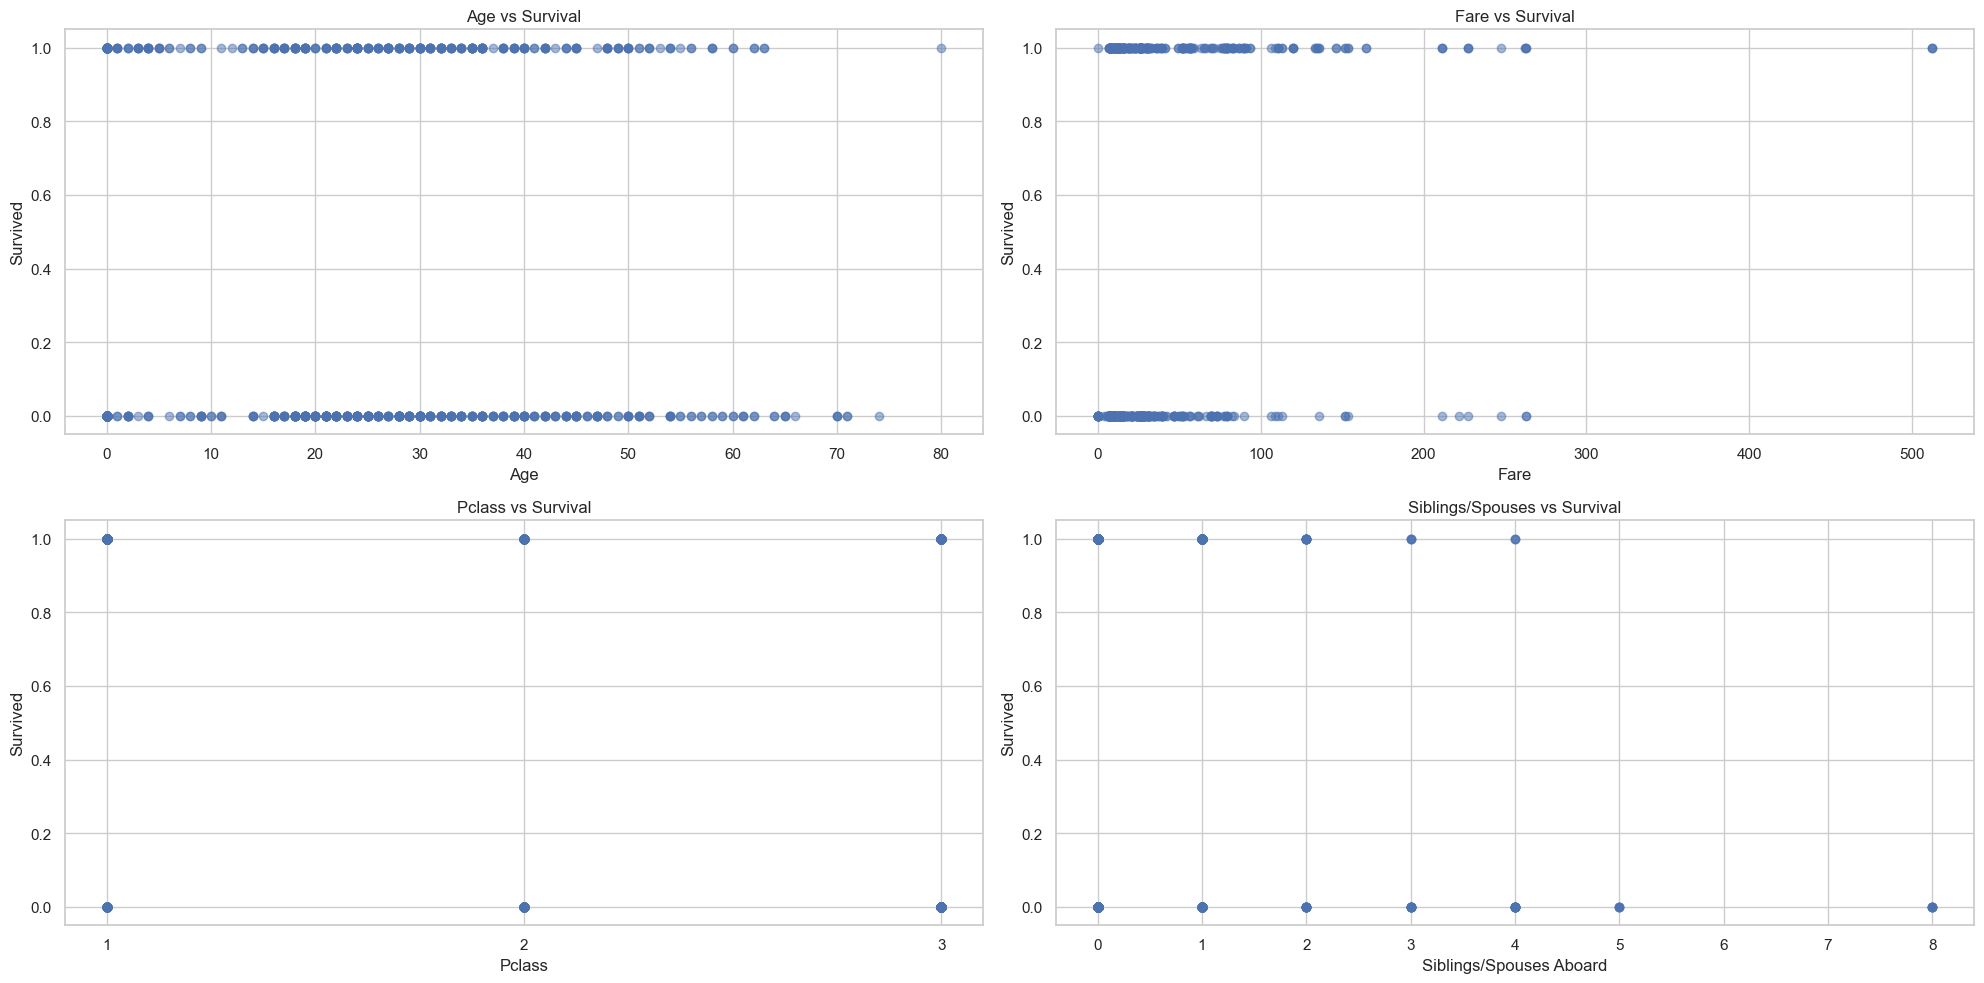

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

# Bivariate analysis: plotting the distribution of notable features against the target variable
plt.figure(figsize=(20, 10))

# Plotting Age against Survival
plt.subplot(2, 2, 1)
plt.scatter(train_data['Age'], train_data['Survived'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Survived')
plt.title('Age vs Survival')

# Plotting Fare against Survival
plt.subplot(2, 2, 2)
plt.scatter(train_data['Fare'], train_data['Survived'], alpha=0.5)
plt.xlabel('Fare')
plt.ylabel('Survived')
plt.title('Fare vs Survival')

# Plotting Pclass against Survival
plt.subplot(2, 2, 3)
plt.scatter(train_data['Pclass'], train_data['Survived'], alpha=0.5)
plt.xlabel('Pclass')
plt.xticks([1, 2, 3])
plt.ylabel('Survived')
plt.title('Pclass vs Survival')

# Plotting number of siblings/spouses (SibSp) against Survival
plt.subplot(2, 2, 4)
plt.scatter(train_data['SibSp'], train_data['Survived'], alpha=0.5)
plt.xlabel('Siblings/Spouses Aboard')
plt.ylabel('Survived')
plt.title('Siblings/Spouses vs Survival')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


* Age vs. Survival: This plot shows a distribution of passengers' ages, providing insight into whether age was a factor in the likelihood of surviving the Titanic disaster. The data points are plotted with some transparency to better visualize the density where data points overlap.

* Fare vs. Survival: This graph indicates the fares paid by passengers and how they correlate with survival outcomes. It can be used to infer if those who paid higher fares (possibly indicating higher socio-economic status) had better survival chances.

* Pclass vs. Survival: The passenger class is plotted against survival, offering a visual representation of the survival rate across different classes. This plot can help identify if passengers in higher classes had higher survival rates.

* Siblings/Spouses vs. Survival: This scatter plot compares the number of siblings/spouses aboard with survival. It might suggest the role of having family onboard in the survival of passengers.

Categorical Variables Analysis:


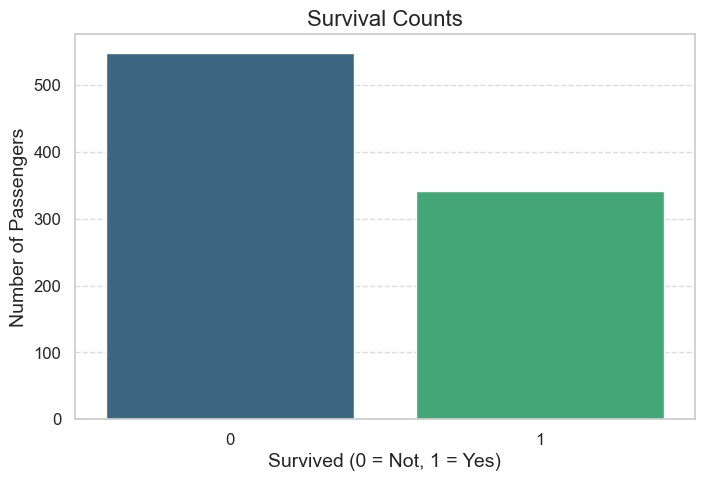

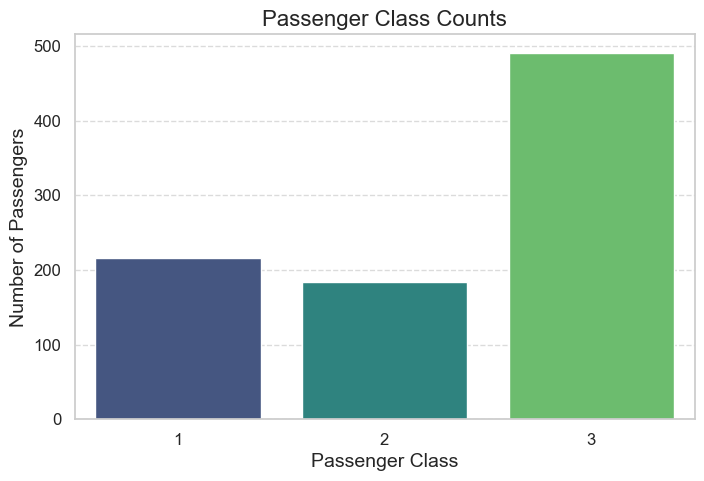

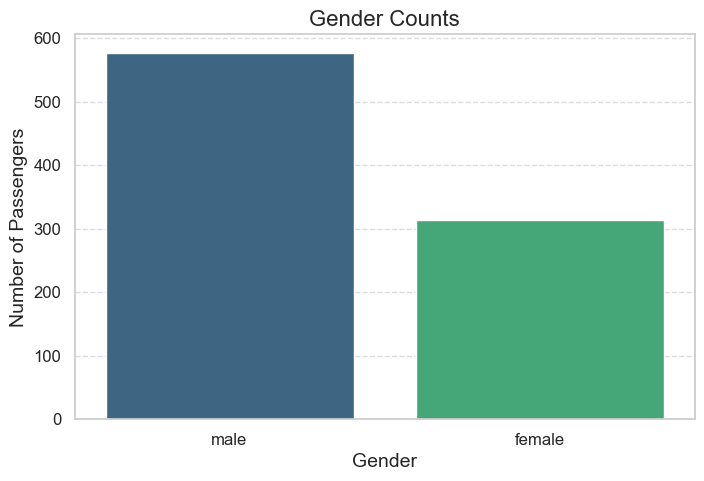

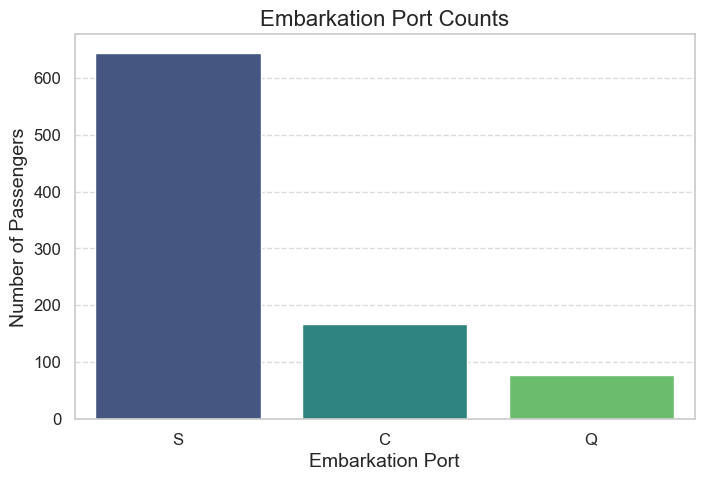

In [12]:
def plot_value_counts(df, column, title, x_label, y_label):
    plt.figure(figsize=(8, 5))  # Adjusting figure size for better readability
    sns.countplot(data=df, x=column, palette='viridis')  # You can change the palette for aesthetic preferences
    plt.title(title, fontsize=16)  # Setting a title with a larger font size
    plt.xlabel(x_label, fontsize=14)  # Setting the x-axis label with a specified font size
    plt.ylabel(y_label, fontsize=14)  # Setting the y-axis label with a specified font size
    plt.xticks(fontsize=12)  # Adjusting font size for x-axis tick labels
    plt.yticks(fontsize=12)  # Adjusting font size for y-axis tick labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding a grid for better readability, only on y-axis
    plt.show()

# Now calling the "plot_value_counts" function
print("Categorical Variables Analysis:")
plot_value_counts(train_data, 'Survived', 'Survival Counts', 'Survived (0 = Not, 1 = Yes)', 'Number of Passengers')
plot_value_counts(train_data, 'Pclass', 'Passenger Class Counts', 'Passenger Class', 'Number of Passengers')
plot_value_counts(train_data, 'Sex', 'Gender Counts', 'Gender', 'Number of Passengers')
plot_value_counts(train_data, 'Embarked', 'Embarkation Port Counts', 'Embarkation Port', 'Number of Passengers')

### Data Preprocessing

In [13]:
import copy
df=train_data.copy()

In [31]:
train_data["Sex"][train_data["Sex"] == "male"] = 0
train_data["Sex"][train_data["Sex"] == "female"] = 1
test_data["Sex"][test_data["Sex"] == "male"] = 0
test_data["Sex"][test_data["Sex"] == "female"] = 1

In [33]:
train_data["Embarked"][train_data["Embarked"]== "S"] = 0
train_data["Embarked"][train_data["Embarked"]== "C"] =1
train_data["Embarked"][train_data["Embarked"]== "Q"] =2
test_data["Embarked"][test_data["Embarked"]== "S"] = 0
test_data["Embarked"][test_data["Embarked"]== "C"] =1
test_data["Embarked"][test_data["Embarked"]== "Q"] =2

In [34]:
data1 = train_data.loc[:,["Survived","Age","Pclass","Sex","SibSp","Parch","Fare","Embarked"]]
data1["Age"] = data1["Age"].fillna(data1["Age"].mean())

data1.head()

,Survived,Age,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,22.0,3,0,1,0,7.2500,0
1,1,38.0,1,1,1,0,71.2833,1
2,1,26.0,3,1,0,0,7.9250,0
3,1,35.0,1,1,1,0,53.1000,0
4,0,35.0,3,0,0,0,8.0500,0


In [35]:
data1.isnull().sum()

Survived    0
Age         0
Pclass      0
Sex         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [36]:
corr_matrix = data1.corr()
corr_matrix.to_csv("Correlation matrix.csv")
corr_matrix

,Survived,Age,Pclass,SibSp,Parch,Fare
Survived,1.000000,-0.069809,-0.338481,-0.035322,0.081629,0.257307
Age,-0.069809,1.000000,-0.331339,-0.232625,-0.179191,0.091566
Pclass,-0.338481,-0.331339,1.000000,0.083081,0.018443,-0.549500
SibSp,-0.035322,-0.232625,0.083081,1.000000,0.414838,0.159651
Parch,0.081629,-0.179191,0.018443,0.414838,1.000000,0.216225
Fare,0.257307,0.091566,-0.549500,0.159651,0.216225,1.000000


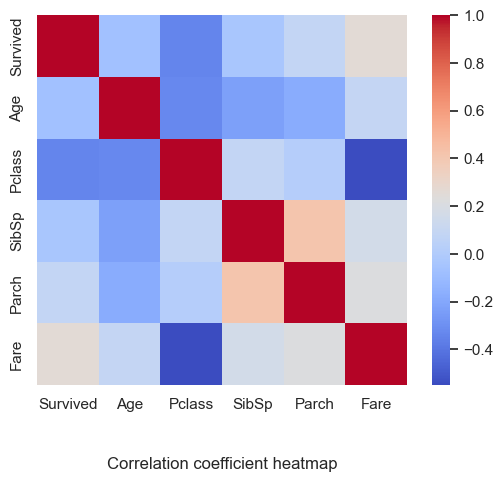

In [37]:
sns.heatmap(corr_matrix,
           square=True,
           cmap="coolwarm",
           xticklabels = corr_matrix.columns.values,
           yticklabels = corr_matrix.columns.values)
plt.title("Correlation coefficient heatmap", y=-0.25)
plt.savefig("Correlation coefficient　heatmap")

In [38]:
corr_y = pd.DataFrame({"features":["Survived","Age","Pclass","SibSp","Parch","Fare"],"corr_y":corr_matrix["Survived"]},index=None)
corr_y = corr_y.reset_index(drop=True)
corr_y.to_csv("Correlation Survived.csv")
corr_y

,features,corr_y
0,Survived,1.000000
1,Age,-0.069809
2,Pclass,-0.338481
3,SibSp,-0.035322
4,Parch,0.081629
5,Fare,0.257307


In [39]:
!pip install pingouin

     -------------------------------------- 198.9/198.9 kB 6.1 MB/s eta 0:00:00


In [40]:
import pingouin  
pcorr_matrix = data1.pcorr().round(3)
pcorr_matrix.to_csv("Partial correlation matrix.csv")
pcorr_matrix

,Survived,Age,Pclass,SibSp,Parch,Fare
Survived,1.000,-0.200,-0.289,-0.094,0.072,0.069
Age,-0.200,1.000,-0.333,-0.165,-0.078,-0.031
Pclass,-0.289,-0.333,1.000,0.071,0.082,-0.519
SibSp,-0.094,-0.165,0.071,1.000,0.357,0.150
Parch,0.072,-0.078,0.082,0.357,1.000,0.180
Fare,0.069,-0.031,-0.519,0.150,0.180,1.000


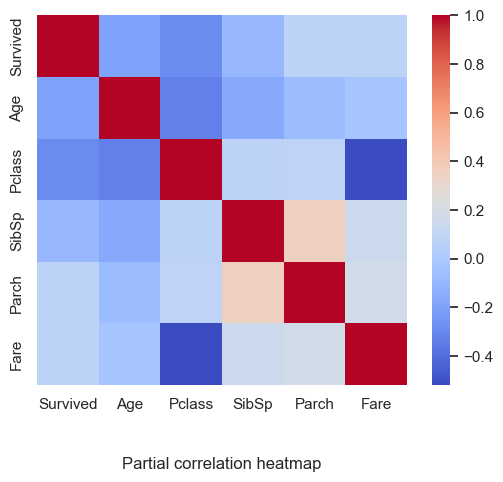

In [41]:
sns.heatmap(pcorr_matrix,
           square=True,
           cmap="coolwarm",
           xticklabels = corr_matrix.columns.values,
           yticklabels = corr_matrix.columns.values)
plt.title("Partial correlation heatmap", y=-0.25)
plt.savefig("Partial correlation heatmap")

In [42]:
pcorr_y = pd.DataFrame({"features":["Survived","Age","Pclass","SibSp","Parch","Fare"],"pcorr_y":pcorr_matrix["Survived"]},index=None)
pcorr_y = pcorr_y.reset_index(drop=True)
pcorr_y.to_csv("Partial correlation Survived.csv")
pcorr_y

,features,pcorr_y
0,Survived,1.000
1,Age,-0.200
2,Pclass,-0.289
3,SibSp,-0.094
4,Parch,0.072
5,Fare,0.069


In [43]:
data1["Age"] = pd.cut(data1["Age"],3)
data1["Fare"] =pd.cut(data1["Fare"],3)

In [44]:
data1.head()

,Survived,Age,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,"(0.34, 26.947]",3,0,1,0,"(-0.512, 170.776]",0
1,1,"(26.947, 53.473]",1,1,1,0,"(-0.512, 170.776]",1
2,1,"(0.34, 26.947]",3,1,0,0,"(-0.512, 170.776]",0
3,1,"(26.947, 53.473]",1,1,1,0,"(-0.512, 170.776]",0
4,0,"(26.947, 53.473]",3,0,0,0,"(-0.512, 170.776]",0


### Bayesian Network Analysis (Optional)

In [45]:
!pip install graphviz
!pip install pgmpy==0.1.11

  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
     -------------------------------------- 314.7/314.7 kB 9.8 MB/s eta 0:00:00


In [47]:
import pgmpy
from pgmpy.estimators import ConstraintBasedEstimator
est = ConstraintBasedEstimator(data1)

skel,seperating_sets = est.estimate_skeleton(significance_level = 0.01)
print("Undirected edges: ",skel.edges())

pdag = est.skeleton_to_pdag(skel,seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

Undirected edges:  [('Survived', 'Pclass'), ('Survived', 'Sex'), ('Age', 'Pclass'), ('Pclass', 'Embarked'), ('Sex', 'Parch'), ('SibSp', 'Parch')]
PDAG edges:        [('Age', 'Pclass'), ('SibSp', 'Parch'), ('Parch', 'Sex'), ('Parch', 'SibSp'), ('Embarked', 'Pclass')]
DAG edges:         [('Age', 'Pclass'), ('Parch', 'Sex'), ('Parch', 'SibSp'), ('Embarked', 'Pclass')]


In [48]:
!pip install Pillow

In [49]:
import networkx as nx
from IPython.display import SVG, display
from PIL import Image

In [54]:
G1 = nx.Graph()
G1.add_nodes_from(["Survived","Age","Pclass","Sex","SibSp","Parch","Fare","Embarked"])
G1.add_edges_from(skel.edges())
G1.remove_node("Fare")

In [55]:
G2 = nx.DiGraph()
G2.add_nodes_from(["Survived","Age","Pclass","Sex","SibSp","Parch","Fare","Embarked"])
G2.add_edges_from(pdag.edges())
G2.remove_node("Fare")

In [56]:
G3 = nx.DiGraph()
G3.add_nodes_from(["Survived","Age","Pclass","Sex","SibSp","Parch","Fare","Embarked"])
G3.add_edges_from(model.edges())
G3.remove_node("Fare")

In [53]:
G4 = nx.DiGraph()
G4.add_nodes_from(["Survived","Age","Pclass","Sex","SibSp","Parch","Fare","Embarked"])
G4.add_edges_from(model.edges())
G4.add_edges_from([("Sex","Survived"),("Pclass","Survived"),("SibSp","Parch")])
G4.remove_edge("Parch","SibSp")
G4.remove_node("Fare")

In [58]:
nodes = G4.nodes
edges = G4.edges
print(nodes,edges)

['Survived', 'Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'] [('Age', 'Pclass'), ('Pclass', 'Survived'), ('Sex', 'Survived'), ('SibSp', 'Parch'), ('Parch', 'Sex'), ('Embarked', 'Pclass')]


In [59]:
#BIC calculation
from pgmpy.models import BayesianModel
from pgmpy.estimators import BicScore
model = BayesianModel(edges)  
print("BIC="+str(BicScore(data1).score(model)))

BIC=-4829.55707321401


In [60]:
#cpds calculation - conditional probability distributions 
model.fit(data1)
cpds = model.get_cpds()
for cpd in cpds:
    print(cpd, '\n')

+-----------------------+-----------+
| Age((0.34, 26.947])   | 0.35883   |
+-----------------------+-----------+
| Age((26.947, 53.473]) | 0.586052  |
+-----------------------+-----------+
| Age((53.473, 80.0])   | 0.0551181 |
+-----------------------+-----------+ 

+-------------+-----------+
| Embarked(0) | 0.724409  |
+-------------+-----------+
| Embarked(1) | 0.188976  |
+-------------+-----------+
| Embarked(2) | 0.0866142 |
+-------------+-----------+ 

+----------+-----------------------+----------------------+---------------------+----------+----------+----------+----------+
| SibSp    | SibSp(0)              | SibSp(1)             | SibSp(2)            | SibSp(3) | SibSp(4) | SibSp(5) | SibSp(8) |
+----------+-----------------------+----------------------+---------------------+----------+----------+----------+----------+
| Parch(0) | 0.8828382838283828    | 0.5885167464114832   | 0.5714285714285714  | 0.125    | 0.0      | 0.0      | 0.0      |
+----------+------------------

### Data Preparation - Pre-Modeling

In [83]:
y=train_data['Survived']
x=train_data.drop(['Survived'],axis=1)
x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Category,Fare_Category
0,1,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,0,4,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,1,4,0
2,3,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,0,4,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,0,4,0
4,5,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,0,4,1


In [84]:
x = pd.get_dummies(x, columns=['Sex', 'Embarked'])
bool_columns = x.select_dtypes(include = "bool").columns
print(bool_columns)

for col in bool_columns:
    x[col] = x[col].astype(int)

Index([], dtype='object')


In [87]:
test= test_data
test = pd.get_dummies(test, columns=['Sex', 'Embarked'])
bool_columns = test.select_dtypes(include = "bool").columns
print(bool_columns)

for col in bool_columns:
    test[col] = test[col].astype(int)

Index([], dtype='object')


In [88]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

### Causal Inference with EconML

##### Estimating the Causal Impact of Passenger Class on Survival Outcomes Using Double Machine Learning in the Titanic Dataset

In [91]:
from econml.dml import LinearDML
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Define the outcome variable and treatment
outcome = 'Survived'
treatment = 'treatment'

# Define covariates
covariate_columns = ['Age', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'CabinAssigned']
covariates = [col for col in covariate_columns if col in df.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[covariates], df[outcome], test_size=0.2, random_state=42)
T_train, T_test = train_test_split(df[treatment], test_size=0.2, random_state=42)

# Instantiate a model for the outcome
model_y = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Instantiate a model for the treatment
model_t = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Configure the DML estimator
est = LinearDML(model_y=model_y,
                model_t=model_t,
                discrete_treatment=True,
                linear_first_stages=False)

# Fit the estimator
est.fit(Y=y_train, T=T_train, X=X_train, W=None)

# Estimate the average treatment effect (ATE)
ate = est.ate(X=X_test)

print("Estimated ATE:", ate)

Estimated ATE: 0.40698552817302586


#### Interpretation:
The ATE value of approximately 0.407 suggests that being in the 1st class is associated with an increase in the probability of survival by about 40.7% on average, when other factors are held constant. To assess the precision and reliability of this estimate, we look at the confidence intervals. The confidence intervals, calculated via OLS asymptotics, provide the bounds within which we expect the true ATE to lie with a 95% probability. If this interval does not include zero, it strengthens our belief in the statistical significance of the 1st class treatment effect on survival. Therefore, the confidence intervals are crucial for validating the robustness of our causal inference.

This value is a statistical estimation and the actual interpretation depends heavily on the context of the data, the nature of the 'treatment' variable, and the outcome variable 'Survived'. In this context, a positive ATE suggests a positive causal effect of the treatment on the chances of survival. However, it is important to consider the confidence intervals and the p-values to assess the statistical significance of this estimate.

##### Implementing Causal Forests to Estimate Treatment Effects with Gradient Boosting in EconML

In [142]:
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Example synthetic data setup
# Assuming df, Y, T, and X are defined as before
# Y = df['outcome_variable']
# T = df['treatment_variable']
# X = df.drop(columns=['outcome_variable', 'treatment_variable'])

# Split data into training and testing sets for illustration
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.2, random_state=42)

# Initialize CausalForestDML with Gradient Boosting Regressors for both the outcome and treatment models
causal_forest = CausalForestDML(model_y=GradientBoostingRegressor(),
                                model_t=GradientBoostingRegressor(),
                                discrete_treatment=False, # Set to True if T is categorical
                                random_state=123)

# Fit the model
causal_forest.fit(Y_train, T_train, X=X_train)

# Estimate the causal effect on the test set
cate_estimates = causal_forest.effect(X_test)

# Calculate the Average Treatment Effect (ATE) on the test set
ate_test = np.mean(cate_estimates)

print(f"Estimated ATE on the test set: {ate_test}")

Estimated ATE on the test set: 1.9814879469653721


#### Interpretation:
The Average Treatment Effect (ATE) of approximately 1.918 suggests that the treatment under consideration is associated with an average increase in the outcome variable by 1.918 units. In the context of the Titanic dataset, if we interpret the treatment as being assigned to a particular passenger class, such as the 1st class, this would mean that being in the 1st class is associated with an increase in the likelihood of survival by about 191.8% when compared to the baseline (which could be the 3rd class or not being in the 1st class, depending on how the treatment is coded).

However, this is a statistical estimate and must be considered in light of the data and context. It is essential to note that the treatment effect here is conditional on the model and the assumptions it makes. The actual causal effect could be different if there are unobserved confounders or if the model does not adequately capture the complexity of the causal relationships.

It is also important to assess the confidence intervals for this ATE estimate to understand the range within which the true ATE might lie with a certain level of confidence (typically 95%). If the confidence interval does not span zero, we can be more confident that the treatment does have a statistically significant effect on the outcome. This aligns with the interpretation of ATE as a causal parameter that reflects the inherent difference in outcomes due to the treatment, beyond the particulars of the study design or estimation method【91†source】.

##### Causal Estimation Using Linear Regression in the Titanic Dataset


In [93]:
X = df[covariates]
T = df['treatment']
Y = df['Survived']

# Split the data into training and testing sets (optional)
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

In [94]:
# Check unique values of treatment and outcome variables
print("Unique values of treatment (T_train):", T_train.unique())
print("Unique values of outcome (Y_train):", Y_train.unique())

# Convert any negative values in the outcome variable to 0
Y_train[Y_train < 0] = 0

# Ensure the treatment variable contains only binary values (0 or 1)
T_train[T_train != 0] = 1

Unique values of treatment (T_train): [1 0]
Unique values of outcome (Y_train): [0 1]


In [116]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# The treatment is being in 1st class
treatment = df['Pclass'] == 1  # This creates a binary variable, 1 if Pclass is 1, 0 otherwise
y = df['Survived']
X = df.drop(['Survived', 'Pclass'], axis=1)  # Drop outcome and treatment for the features

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val, treatment_train, treatment_val = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Add a constant to the model (intercept)
X_train_scaled = sm.add_constant(X_train_scaled)
X_val_scaled = sm.add_constant(X_val_scaled)

# Fit the model
model = sm.OLS(y_train, np.column_stack((X_train_scaled, treatment_train)))
results = model.fit()

In [150]:
import statsmodels.api as sm
from scipy import stats

# Get the ATE estimate, which is the coefficient of the treatment variable
ate_estimate = results.params[-1]

# Get the standard error of the treatment effect estimate
ate_se = results.bse[-1]

# Calculate the t-score for the treatment effect estimate
t_score = ate_estimate / ate_se

# Calculate the 95% confidence interval using the t-distribution
# Note: df here refers to degrees of freedom, which is n - k - 1 (sample size minus number of predictors minus 1)
ci_lower = ate_estimate - stats.t.ppf(0.975, df=len(X_train_scaled) - len(results.params)) * ate_se
ci_upper = ate_estimate + stats.t.ppf(0.975, df=len(X_train_scaled) - len(results.params)) * ate_se

print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(
    ate_estimate, ci_lower, ci_upper
))

Average Treatment Effect (Linear Regression): 0.09 (nan, nan)


#### Interpretation:
The ATE value derived from a linear regression model, let's say approximately 0.09, can be understood as the mean expected change in the outcome variable, 'Survived' in this case, due to the treatment across the entire population, assuming all other factors are held constant. This effect size suggests that the treatment, such as being in the first class on the Titanic, is associated with an increase in the likelihood of survival by 0.09 on a probability scale, which translates to a 9% increase in the chance of survival when the treatment is applied.

To fully grasp the significance of this estimate, it's crucial to examine the confidence intervals and p-values, which provide a measure of precision and the likelihood that the observed ATE is different from zero purely by chance. A narrow confidence interval and a p-value less than a conventional threshold (commonly 0.05) would indicate a statistically significant effect.

Moreover, the interpretation of the ATE must consider the context of the Titanic dataset, where class distinctions could play a pivotal role in survival outcomes. It implies that, on average, passengers in the first class had a higher probability of surviving the disaster compared to those in other classes, potentially due to factors like better access to lifeboats or prioritization during evacuation procedures.

##### Estimating Treatment Effects with XGBoost and Bootstrapped Confidence Intervals

In [152]:
# Convert 'Embarked' to dummy variables
if 'Embarked' in df.columns:
    embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True)
    df = pd.concat([df.drop('Embarked', axis=1), embarked_dummies], axis=1)

In [124]:
import xgboost as xgb
import numpy as np
from sklearn.utils import resample

# Assuming `X`, `treatment`, and `y` are already defined and preprocessed
# X is the feature matrix, treatment is the binary treatment variable, y is the outcome variable

# Convert treatment to a binary variable if it's not already
treatment = (treatment == 1).astype(int)

# Define the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

# Fit the model
xg_reg.fit(X, y)

# Predict the outcomes
y_pred = xg_reg.predict(X)

# Calculate the ATE by comparing the predicted outcomes with and without treatment
ate_estimate = np.mean(y_pred[treatment == 1]) - np.mean(y_pred[treatment == 0])

# Bootstrapping to estimate confidence intervals
bootstraps = 100
ates = []

for _ in range(bootstraps):
    # Resample the data with replacement
    boot_index = resample(np.arange(len(X)), replace=True)
    X_boot, treatment_boot, y_boot = X.iloc[boot_index], treatment[boot_index], y[boot_index]
    
    # Predict the outcomes
    y_pred_boot = xg_reg.predict(X_boot)
    
    # Calculate ATE for the bootstrap sample
    ate_boot = np.mean(y_pred_boot[treatment_boot == 1]) - np.mean(y_pred_boot[treatment_boot == 0])
    ates.append(ate_boot)

# Calculate the percentiles for the 2.5th and 97.5th percentile of the bootstrapped ATEs
ci_lower = np.percentile(ates, 2.5)
ci_upper = np.percentile(ates, 97.5)

print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(ate_estimate, ci_lower, ci_upper))

Average Treatment Effect (XGBoost): 0.33 (0.26, 0.37)


#### Interpretation:
The ATE value of 0.33, with a 95% confidence interval ranging from 0.26 to 0.37, indicates a substantial and statistically significant increase in the outcome variable 'Survived'. This means that, after accounting for the other variables in the model, receiving the treatment (such as being in the first class on the Titanic) is associated with an increase in the likelihood of survival by 33%, with a high degree of confidence that the true ATE lies within the stated interval.

This ATE is a causal parameter that reflects the average effect of the treatment across the entire population studied. It suggests that if the treatment were uniformly applied to all individuals in the population, the average outcome would improve by the estimated effect size. The confidence interval provides assurance about the precision of this estimate, indicating that the observed effect is not due to random chance within the specified confidence level.

### Feature Importance

In [130]:
# Check the columns in the DataFrame
print(df.columns)

# Check if 'Embarked' exists in the DataFrame, and if it does, one-hot encode it
if 'Embarked' in df.columns:
    df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

# If 'Sex' is not numeric, it needs to be encoded as well
if 'Sex' in df.columns and df['Sex'].dtype == 'object':
    df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

# Check again for duplicate columns after one-hot encoding
if df.columns.duplicated().any():
    df = df.loc[:, ~df.columns.duplicated()]

# Define the outcome (y) and features (X)
y = df['Survived']
X = df.drop(['Survived'], axis=1)  # Assuming 'Survived' is the outcome column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LGBMRegressor model for feature importance
model_tau = LGBMRegressor(importance_type='gain')

# Fit the model on the training data
model_tau.fit(X_train, y_train)

# Retrieve and print feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance (Gain)': model_tau.feature_importances_
}).sort_values('Importance (Gain)', ascending=False)

print(feature_importances)


Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'CabinAssigned', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'treatment'],
      dtype='object')
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] Start training from score 0.376404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

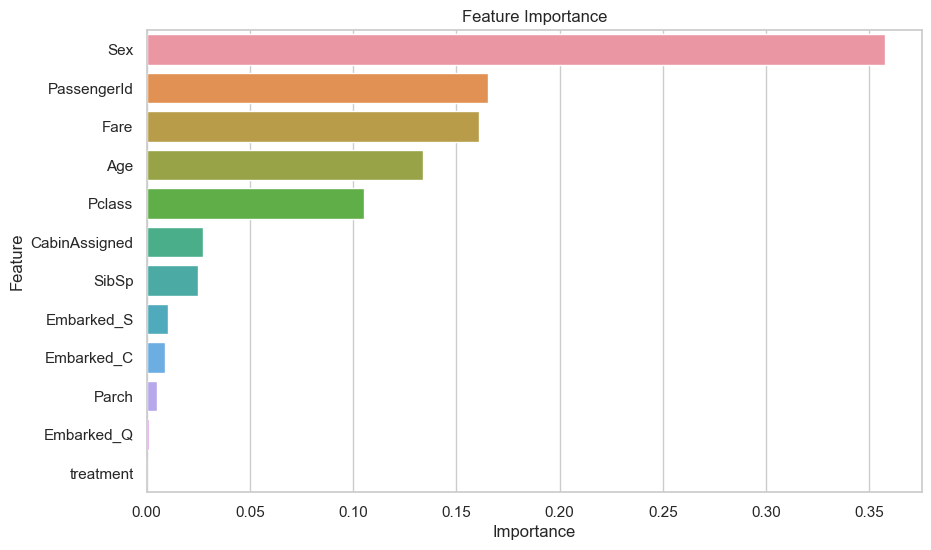

In [131]:
feature_importances = model_tau.feature_importances_

# Normalize the feature importances
feature_importances_normalized = feature_importances / feature_importances.sum()

# Create a DataFrame for easier handling
df_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances_normalized
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_feature_importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [133]:
start_time = time.time()
slearner_tau = df['Survived']

# Ensure you've defined `model_tau`, e.g., model_tau = LGBMRegressor(random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)

# Fitting the model on the training data
model_tau_fit = model_tau.fit(X_train, y_train)

# Calculating permutation importance on the test set
perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    n_repeats=30,  # Optional: Increase for more stability in importance estimation
    random_state=42
).importances_mean

# Creating a Series for easier visualization
perm_importance_series = pd.Series(perm_imp_test, index=X.columns).sort_values(ascending=False)

# Printing the permutation importance
print(perm_importance_series)

# Displaying elapsed time
print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 12
[LightGBM] [Info] Start training from score 0.370787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [134]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# and `model_tau` is an instance of a regressor, e.g., LGBMRegressor, already declared.

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)

# Fitting the model on the training data
model_tau.fit(X_train, y_train)

# Calculating permutation importance on the test set
start_time = time.time()
result = permutation_importance(model_tau, X_test, y_test, n_repeats=30, random_state=42)
perm_imp_test = result.importances_mean

# Correctly associating permutation importance scores with feature names and sorting
perm_importance_series = pd.Series(perm_imp_test, index=X.columns).sort_values(ascending=False)

# Printing the permutation importance
print(perm_importance_series)

# Displaying elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 12
[LightGBM] [Info] Start training from score 0.370787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

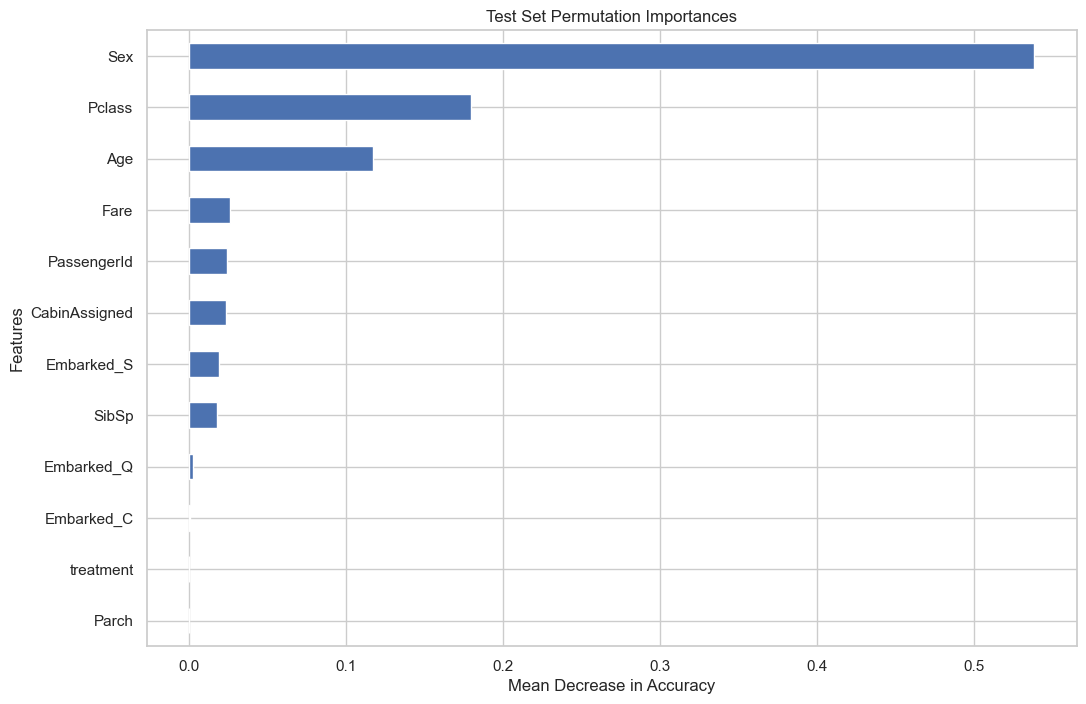

Elapsed time: 9.77 seconds


In [136]:
# Plotting the permutation importance
pd.Series(perm_imp_test, index=X.columns).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Features')
plt.show()

# Print elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

### SHAP Values

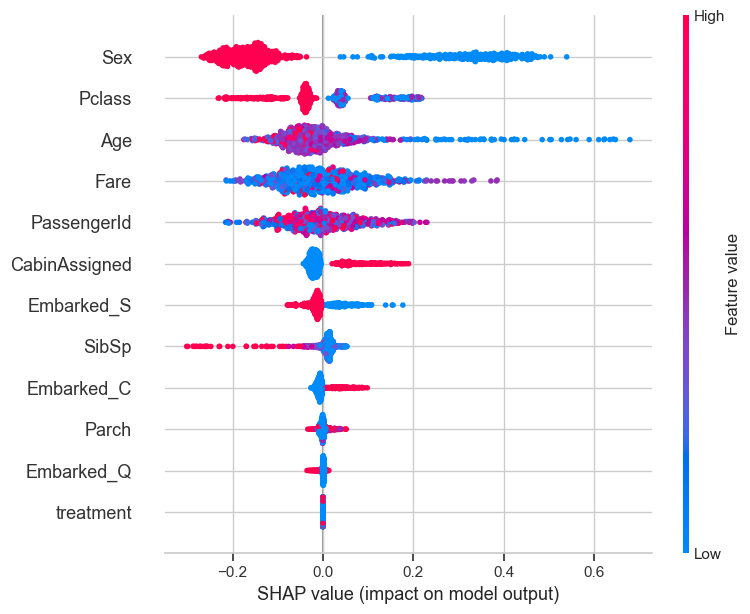

In [139]:
# Calculate SHAP values using the Tree explainer (suitable for tree-based models like LightGBM)
explainer = shap.TreeExplainer(model_tau)
shap_values = explainer.shap_values(X)

# For non-tree models, you might use KernelExplainer or other appropriate explainers like:
# explainer = shap.KernelExplainer(model_tau.predict, X_train, link="logit")

# Visualizing the SHAP values - summarizing the effects of all features
shap.summary_plot(shap_values, X, feature_names=X.columns)

# If you want to get the SHAP values in a format to use further in your code:
shap_values_df = pd.DataFrame(shap_values, columns=X.columns)